<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/GANS_IN_ACTION_Chapter_4_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장: 심층 합성곱 GAN (DCGAN)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자

In [3]:
def build_generator(z_dim):

    model = Sequential()

    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Activation('tanh'))

    return model

## 판별자

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## 모델 만들기

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    import time
    start = time.time()  # 시작 시간 저장        

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        # z = np.random.normal(0, 1, (batch_size, 100))
        # gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## GAN 훈련과 출력 점검

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.319330, 정확도: 86.72%] [G 손실: 3.043468]
time : 154.1450798511505


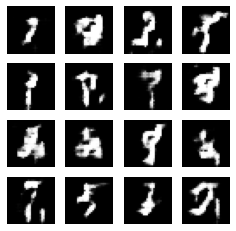

2000 [D 손실: 0.616963, 정확도: 67.58%] [G 손실: 1.395978]
time : 303.1955008506775


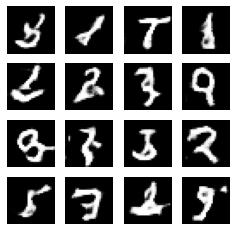

3000 [D 손실: 0.499114, 정확도: 73.44%] [G 손실: 1.777622]
time : 445.4469530582428


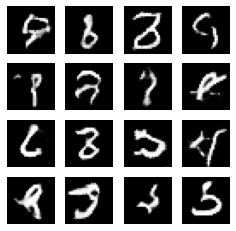

4000 [D 손실: 0.477968, 정확도: 76.95%] [G 손실: 1.784951]
time : 585.1093518733978


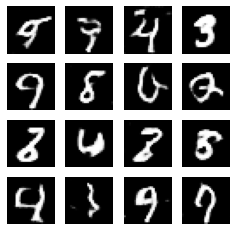

5000 [D 손실: 0.377251, 정확도: 83.98%] [G 손실: 2.147344]
time : 724.7630422115326


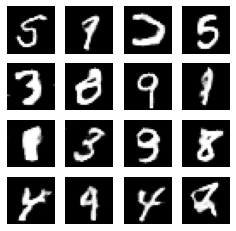

6000 [D 손실: 0.389356, 정확도: 81.64%] [G 손실: 1.833687]
time : 860.7633755207062


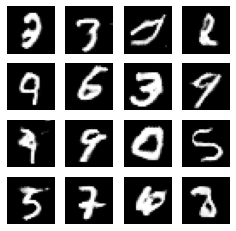

7000 [D 손실: 0.394415, 정확도: 82.81%] [G 손실: 1.921659]
time : 996.8668124675751


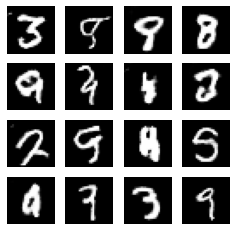

8000 [D 손실: 0.482592, 정확도: 75.00%] [G 손실: 1.984008]
time : 1130.9773044586182


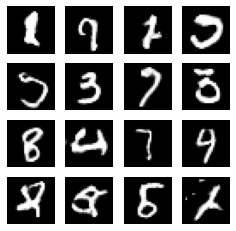

9000 [D 손실: 0.404435, 정확도: 79.30%] [G 손실: 1.943471]
time : 1267.113434791565


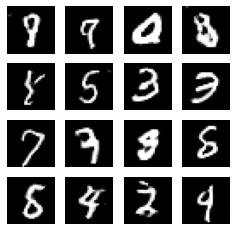

10000 [D 손실: 0.378194, 정확도: 82.81%] [G 손실: 1.910982]
time : 1402.7825706005096


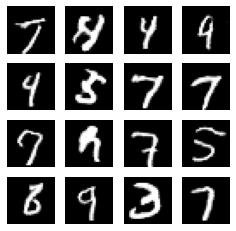

11000 [D 손실: 0.458269, 정확도: 79.30%] [G 손실: 1.862975]
time : 1539.1840705871582


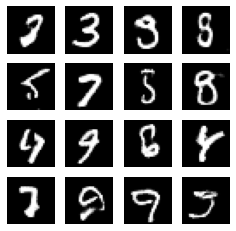

12000 [D 손실: 0.360711, 정확도: 82.42%] [G 손실: 2.081143]
time : 1676.687534570694


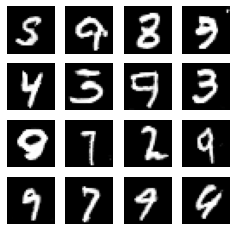

13000 [D 손실: 0.455986, 정확도: 78.91%] [G 손실: 1.815980]
time : 1814.2012434005737


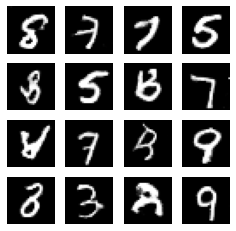

14000 [D 손실: 0.394906, 정확도: 83.20%] [G 손실: 2.061666]
time : 1952.676171541214


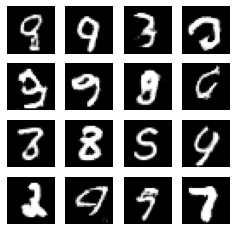

15000 [D 손실: 0.330220, 정확도: 84.77%] [G 손실: 2.503249]
time : 2091.1396844387054


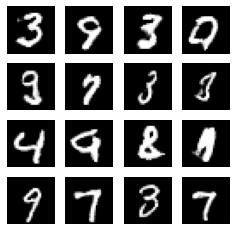

16000 [D 손실: 0.309093, 정확도: 86.72%] [G 손실: 2.578104]
time : 2229.151930332184


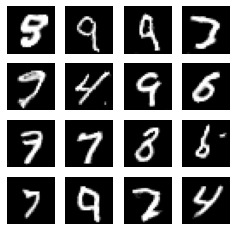

17000 [D 손실: 0.365907, 정확도: 82.81%] [G 손실: 1.962347]
time : 2367.687045812607


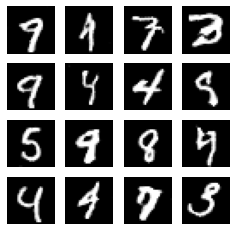

18000 [D 손실: 0.356445, 정확도: 83.59%] [G 손실: 2.031486]
time : 2510.188922405243


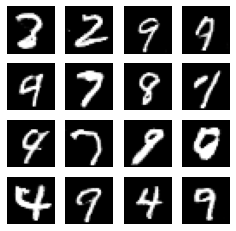

19000 [D 손실: 0.314351, 정확도: 87.11%] [G 손실: 2.161173]
time : 2650.2262291908264


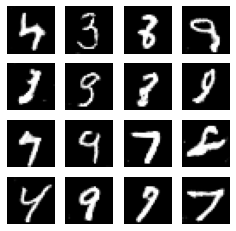

20000 [D 손실: 0.333076, 정확도: 85.16%] [G 손실: 2.282689]
time : 2787.717070579529


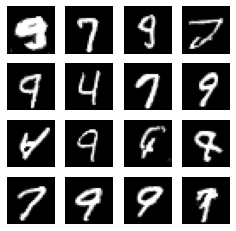

In [9]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

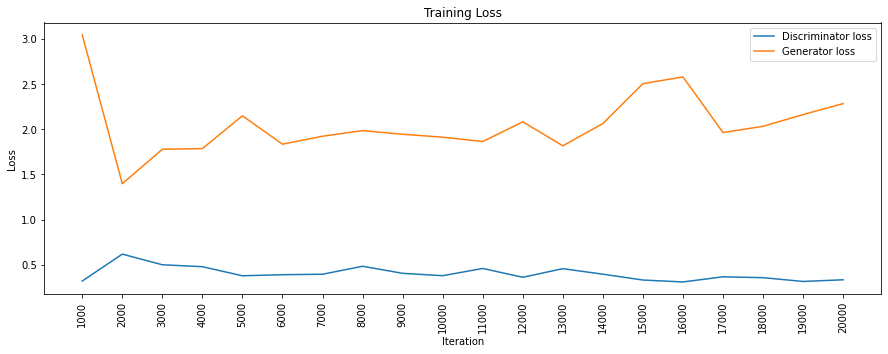

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

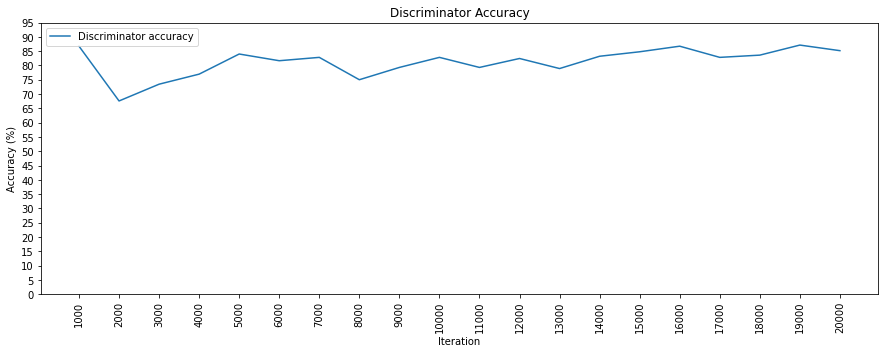

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()